### Functions package and data loading

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from scipy import interp
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
import matplotlib as matplotlib
import seaborn as sns
from numpy import loadtxt
import xgboost as xgb


Xtest = np.loadtxt("Xtest.csv", delimiter=' ')
Xtrain = np.loadtxt("Xtrain.csv", delimiter=' ' )
Ytrain = np.loadtxt("Ytrain.csv", delimiter=' ')

In [51]:
## ROC-AUC, accuracy and AUC-PR metrics in one

def evaluation_metrics(X, classifier, print_summary = True, has_decision_function = False):
    # INPUT: 
    # X - the design matrix.
    # classifier - the predefined classifier/model
    # print_summary - a concise mean, standard deviation report will be returned
    #                 including the results for all the folds.
    # has_decision_function - probabilistic models such as perceptron, SVM in sklearn have 
    #                 inbuilt decision_function to define threshold. It is prefered to use that.
    # OUTPUT:
    # 2 dictionaries for means and standard deviations of all the metrics taken across all folds.
    
    # lists to contain the results for all 3 classifiers
    roc =[]
    pr = []
    accuracy = []
   
    for i, (train, test) in enumerate(skf.split(X, Ytrain)):
        classifier.fit(X[train], Ytrain[train])
        
        # checking which attribute to use to define the threshold
        # using "predict_proba" or "decision_function" for a more accurate evaluation than
        # with the crude predicted scores obtained with "predict".
        if has_decision_function == False:
            probs = classifier.predict_proba(X[test])
            preds = probs[:,1]
        elif has_decision_function == True:
            preds = classifier.decision_function(X[test])
        
        # calculating ROC-AUC score
        fpr,tpr,tt = roc_curve(Ytrain[test], preds)
        roc_score = auc(fpr, tpr)
        
        # calculating PR-AUC score
        pr_score = average_precision_score(Ytrain[test], preds)
        
        # manually defining accuracy
        accuracy_score = np.mean(Ytrain[test] == classifier.predict(X[test]))
        
        # storing the values for each fold
        roc.append(roc_score)
        pr.append(pr_score)
        accuracy.append(accuracy_score)
    
    # creating dictionaries for means and standard deviations of the performance metrics
    means = {'roc':np.mean(roc),'pr': np.mean(pr),'accuracy':np.mean(accuracy)}
    stds ={'roc': np.std(roc),'pr': np.std(pr),'accuracy':np.std(accuracy)}
    
    # a "wordy" summary
    if print_summary == True:
        print('ROC-AUC scores for each fold;', roc)
        print("ROC-AUC: %0.2f (+/- %0.2f)" % (np.mean(roc), np.std(roc) * 2))
        print('PR-AUC scores for each fold;', pr)
        print("AUC-PR: %0.2f (+/- %0.2f)" % (np.mean(pr), np.std(pr) * 2))
        print('Accuracy score for each fold;',accuracy)
        print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(accuracy), np.std(accuracy) * 2))
        
    return means, stds

## Question 1
### Showing the data

There are 3000 rows (images) of training data with corespoinding 3000 labels. 

In [52]:
print(Xtrain.shape)
print(Ytrain.shape)

(3000, 784)
(3000,)


The images depict clothing, shoes, purses. The classification rule is not clear for me.

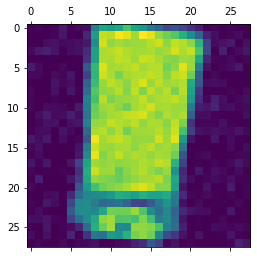

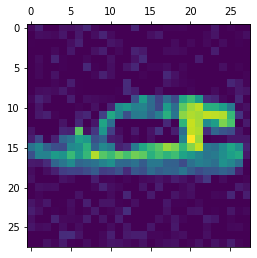

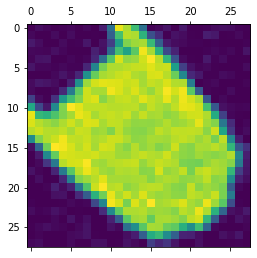

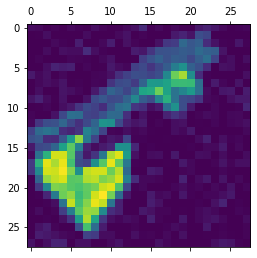

In [53]:
# creating sub-variables to show 1 and -1 labelled images
pos = Xtrain[Ytrain == 1]
neg = Xtrain[Ytrain == -1]

# can change the range if wanted.
for i in range(10,12): 
    image_pos = np.reshape(pos[i], (28,28))
    image_neg = np.reshape(neg[i], (28,28))
    # images will alternative between positive and negative labelled ones
    plt.matshow(image_pos)
    plt.matshow(image_neg)

### Positive/ negative count 

There are 1821 negatives and 1179 positive labels. Thus, the data is moderately imbalanced with a rough 60/40 split (dominated by negatives).

In [54]:
np.unique(Ytrain, return_counts=True)

(array([-1.,  1.]), array([1821, 1179]))

### Choice of a performance metric


Due to the imbalance of the data, accuracy seems to be not the most appropriate performace evaluation tool owing to its bias toward the dominant category. Thus, AUC-ROC or AUC-PR are prefered options. The choice among these two metrics depends on the severity of the imbalance and the weight we put on correctly predicting the positive class (and thus precision). Since (1) the skew of the data is not severe (60/40), (2) no information is given about the goals of prediction and the fact that (3) the nature of the data (clothing) does not suggest that False Positives or False Negatives are more costly, I decided to use AUC-ROC as the performace evaluation metric. 

### Random classifier accuracy

In general, a random classifier is expected to predict 50% of the labels correctly, yet we could derive a slightly more sphisticated expectation of the random classifier which would allow to incorporate different rates of predicting a certain group (predicting everything is of one class is as random as predicting 50/50 split). Accuracy is defined as a ratio of correctly labeled instances (True positives + True negetives) to the total population. To calculate expected confussion matrix terms, let's define $q$ as a probability that a random classifier assigns a positive label to a random input. In addition, recall that our training data has 60% of negative and 40% of positive indtances. Then the expected proportions of all the confussion matrix terms are:

$TP = 0.4q \\
TN = (1-q)0.6 \\
FP = 0.6q\\
FN = (1-q)0.4$

Hence the expected accuracy of a random classifier is $TP+TN = 0.6-0.2q$, which for $q=0.5$ results in accuracy being 50%. 

### ROC-AUC and PR-AUC for a random classifier

AUC-ROC curve is defined as the area under the true positive rate (TPR) against the false positive rate (FPR) curve. 

$TPR = \frac{TP}{FN+TP}= \frac{0.4q}{(1-q)0.4+0.4}=q \\
FPR = \frac{FP}{FP+TN}= \frac{0.6q}{(1-q)0.6+0.6}=q$

Hence the expectation of TPR over the range of FPR is:

$\int_0^1qdq=\frac{q^2}{2}|_0^1=1/2$

And since the expected AUC-ROC does not depend on the proportion of the data, the same result holds for the testing data.

AUC-PR, on the other hand is defined as the are under the precision against TPR curve. For the testing data is follows that:

$Precision = \frac{TP}{TP+FP}=\frac{0.4q}{0.4q+0.6q}=0.4$

Hence the expected training AUC-PR is

$\int_0^10.4qd=0.4q|_0^1 = 0.4$

By the same reasoning, it follows that expected random classifier AUC-PR for the testing data would be equal to the proportion of positive items in a data.

## Question 2

After fitting the model, I am plotting ROC and PR curves that also lists the corresponding AUC scores for each of 5 folds. Following that, I give a more concise report of all the three performance metrics.

In [55]:
# fitting the model for k=1 together with the Stratified 5-folds used in all the assignment.
sknn = KNeighborsClassifier(n_neighbors=1)

skf = StratifiedKFold(n_splits=5)

### Performance of KNN with K=1 classifier

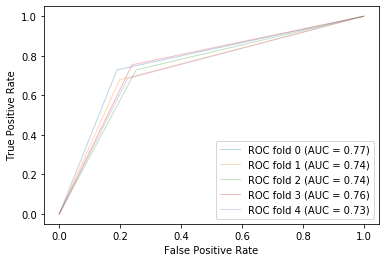

In [56]:
# AUC-ROC for each fold. sklearn 22.1 or later required
# AUC-ROC with plots.
aucs = []

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    # requires sklearn 22.1
    viz = plot_roc_curve(sknn, Xtrain[test], Ytrain[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    aucs.append(viz.roc_auc) 

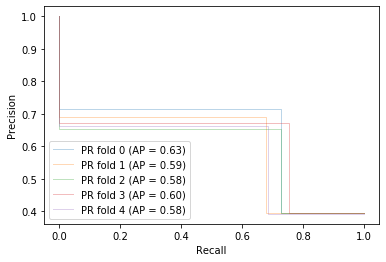

In [57]:
# AUC-PR curve
# requires sklearn 22.1
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    viz = plot_precision_recall_curve(sknn, Xtrain[test], Ytrain[test],
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)

A more concise report of ROC-AUC, PR-AUC and accuracy scores for each fold is printed bellow.

In [58]:
# getting summary for all 3 metrics using own-made function.

base_score, base_stds = evaluation_metrics(Xtrain, sknn)

ROC-AUC scores for each fold; [0.7696265598807971, 0.7400819519463588, 0.7380331532873905, 0.7576131495623021, 0.730224424366074]
ROC-AUC: 0.75 (+/- 0.03)
PR-AUC scores for each fold; [0.6268157629462925, 0.5942294954217806, 0.5814997431946585, 0.6032864300181217, 0.5772515541546274]
AUC-PR: 0.60 (+/- 0.04)
Accuracy score for each fold; [0.7783333333333333, 0.7533333333333333, 0.74, 0.7583333333333333, 0.74]
Accuracy: 0.75 (+/- 0.03)


### Performance summary for KNN, K=1
Using previously used function, I list the mean and standard deviation of each performance measure.

In [59]:
# Mean of the evaluation metrics for KNN the k = 1,  5 Stratified folds
base_score

{'roc': 0.7471158478085845,
 'pr': 0.5966165971470961,
 'accuracy': 0.7539999999999999}

In [60]:
# Standard deviation for KNN the k = 1,  5 Stratified folds
base_stds

{'roc': 0.014382049358744492,
 'pr': 0.017695754878847423,
 'accuracy': 0.01416568624058385}

ROC-AUC score reaches 0.747 with a relativelly low standard deviation of 0.015. So there is definintelly an increase in predictive power over the random classifier. Yet, the error is still huge. 

### Preprocessing

I am implementing the following transformations: scaling, scaling to a range (between 0:1 and -1:1), robust scaling, mapping to uniform and Gaussian distributions and normalization. Sparse data transformations is not applied because the data is not sparse - all needed values are present. Robust scaling, albeit not neccesary due to the the abscence of strong outliers, is still conducted to deduce the importance of extreme values. I only elaborate more about the highest performing preprocessing methods - scaling, mapping to uniform distribution and normalization.

In [61]:
# Scaling
scaling = preprocessing.StandardScaler().fit(Xtrain)
Xscaled = scaling.transform(Xtrain)

scaled_scores, scaled_stds = evaluation_metrics(Xscaled, sknn)

ROC-AUC scores for each fold; [0.7318401937046004, 0.7423170050288695, 0.764993481095176, 0.7763317191283293, 0.7461964441853688]
ROC-AUC: 0.75 (+/- 0.03)
PR-AUC scores for each fold; [0.5824421972178703, 0.5946940131984997, 0.6166148775894539, 0.6276427153545798, 0.5972080773910206]
AUC-PR: 0.60 (+/- 0.03)
Accuracy score for each fold; [0.7433333333333333, 0.7533333333333333, 0.77, 0.7783333333333333, 0.7566666666666667]
Accuracy: 0.76 (+/- 0.02)


In [62]:
scaled_scores
# 0.7523 ROC-AUC. Slight improvement from the raw data case.

{'roc': 0.7523357686284688,
 'pr': 0.6037203761502848,
 'accuracy': 0.7603333333333333}

In [63]:
# MinMax Scaler - scaling values to [0:1] range
min_max_scaler = preprocessing.MinMaxScaler()
Xtrain_minmax = min_max_scaler.fit_transform(Xtrain)

minmax_scores, _ = evaluation_metrics(Xtrain_minmax, sknn)

ROC-AUC scores for each fold; [0.7626420189979511, 0.7387083255727324, 0.7387781709815608, 0.7589867759359284, 0.7294666278053046]
ROC-AUC: 0.75 (+/- 0.03)
PR-AUC scores for each fold; [0.6181229341022575, 0.5922227880022308, 0.5817586338728176, 0.6052054442732409, 0.5770173037874106]
AUC-PR: 0.59 (+/- 0.03)
Accuracy score for each fold; [0.7716666666666666, 0.7516666666666667, 0.74, 0.76, 0.74]
Accuracy: 0.75 (+/- 0.02)


In [64]:
minmax_scores
# 0.7457 ROC-AUC. Not much improvement from the raw data case.

{'roc': 0.7457163838586955,
 'pr': 0.5948654208075914,
 'accuracy': 0.7526666666666667}

In [65]:
# MaxAbs Scaler - centerint to [-1:1]
# Must be centered at zero a priori

demeaning = preprocessing.StandardScaler(with_std=False).fit(Xtrain)
Xdemeaned = demeaning.transform(Xtrain)
max_abs_scaler = preprocessing.MaxAbsScaler()
Xtrain_maxabs = max_abs_scaler.fit_transform(Xdemeaned)

maxabs_scores, _ = evaluation_metrics(Xtrain_maxabs, sknn)

ROC-AUC scores for each fold; [0.7481607375675173, 0.7394533432669027, 0.7415254237288136, 0.7589867759359284, 0.7255027688720489]
ROC-AUC: 0.74 (+/- 0.02)
PR-AUC scores for each fold; [0.5976955278742087, 0.5923818968626036, 0.5853704417051875, 0.6052054442732409, 0.5701670511834572]
AUC-PR: 0.59 (+/- 0.02)
Accuracy score for each fold; [0.755, 0.7516666666666667, 0.7433333333333333, 0.76, 0.7333333333333333]
Accuracy: 0.75 (+/- 0.02)


In [66]:
maxabs_scores
# 0.7427 ROC-AUC. Worse than the raw data case.

{'roc': 0.7427258098742422,
 'pr': 0.5901640723797396,
 'accuracy': 0.7486666666666666}

In [67]:
# Robust Scaling - takes outliers into account better
robust_scaling = preprocessing.RobustScaler().fit(Xtrain)
Xrobust = robust_scaling.transform(Xtrain)

robust_scores, _ = evaluation_metrics(Xrobust, sknn)

ROC-AUC scores for each fold; [0.7101415533618924, 0.7540510337120506, 0.7304665673309741, 0.726462097224809, 0.7413290585835033]
ROC-AUC: 0.73 (+/- 0.03)
PR-AUC scores for each fold; [0.558632816240544, 0.6112331969608416, 0.5805351866297899, 0.5735494864932866, 0.591081560283688]
AUC-PR: 0.58 (+/- 0.04)
Accuracy score for each fold; [0.7233333333333334, 0.7666666666666667, 0.7416666666666667, 0.735, 0.7516666666666667]
Accuracy: 0.74 (+/- 0.03)


In [68]:
robust_scores
# 0.7325 ROC-AUC. Worse than the raw data - more extreme values are informative of classification. 

{'roc': 0.7324900620426459,
 'pr': 0.58300644932163,
 'accuracy': 0.7436666666666667}

In [69]:
# Uniform distribution transformation

quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
Xuniform = quantile_transformer.fit_transform(Xtrain)

uniform_scores, uniform_stds = evaluation_metrics(Xuniform, sknn)

ROC-AUC scores for each fold; [0.7772397094430993, 0.7458092754702924, 0.7461585025144347, 0.7496507729558578, 0.7589332556106092]
ROC-AUC: 0.76 (+/- 0.02)
PR-AUC scores for each fold; [0.6378478849166785, 0.5988491667853582, 0.5940222415756683, 0.5980667023961055, 0.602082142479094]
AUC-PR: 0.61 (+/- 0.03)
Accuracy score for each fold; [0.7866666666666666, 0.7566666666666667, 0.7516666666666667, 0.755, 0.7583333333333333]
Accuracy: 0.76 (+/- 0.03)


In [70]:
uniform_scores
# 0.7555 ROC-AUC. Slight improvement from the raw data case in all the measures.

{'roc': 0.7555583031988586,
 'pr': 0.6061736276305809,
 'accuracy': 0.7616666666666666}

In [71]:
normal_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
Xnormal = normal_transformer.fit_transform(Xtrain)

normal_scores, _ = evaluation_metrics(Xnormal, sknn)

ROC-AUC scores for each fold; [0.6382473458744645, 0.6685369715030732, 0.6551964984168375, 0.6697941888619855, 0.6693383853104051]
ROC-AUC: 0.66 (+/- 0.02)
PR-AUC scores for each fold; [0.4840882452146049, 0.5091385699532227, 0.49771984770326705, 0.5110573042776433, 0.5067583761310834]
AUC-PR: 0.50 (+/- 0.02)
Accuracy score for each fold; [0.6433333333333333, 0.6683333333333333, 0.6566666666666666, 0.6716666666666666, 0.665]
Accuracy: 0.66 (+/- 0.02)


In [72]:
normal_scores
# 0.6602 ROC-AUC. Significantly worse than the raw data

{'roc': 0.6602226779933532,
 'pr': 0.5017524686559642,
 'accuracy': 0.6609999999999999}

In [73]:
# making each row to be unit lenght by L2 norm.
Xnormalized = preprocessing.normalize(Xtrain, norm='l2')

normalized_scores, normalized_stds = evaluation_metrics(Xnormalized, sknn)

ROC-AUC scores for each fold; [0.7849227044142297, 0.7641320543862917, 0.7537250884708513, 0.7497671819705717, 0.7209268434858642]
ROC-AUC: 0.75 (+/- 0.04)
PR-AUC scores for each fold; [0.6345537144784551, 0.6183235328029516, 0.5948774539690282, 0.5965418473262383, 0.5622476813966175]
AUC-PR: 0.60 (+/- 0.05)
Accuracy score for each fold; [0.7833333333333333, 0.7716666666666666, 0.75, 0.7533333333333333, 0.725]
Accuracy: 0.76 (+/- 0.04)


In [74]:
normalized_scores
# 0.7546 ROC-AUC. Slightly better than the raw data.

{'roc': 0.7546947745455618,
 'pr': 0.6013088459946582,
 'accuracy': 0.7566666666666666}

From the above analysis only scaling, normalization and mapping to uniform distribution succeeded in slighltly improving ROC-AUC score. I cover all three of these preprocessing methods in slightly more detail.

1. Scaling - the simpliest transformation. The data is column-centred and each column is devided by its standard deviation.

2. Mapping to uniform - a slightly trickier preprocessing method. This preprocessing takes all data and transforms accoring to the quantiles of the uniform distribution - thus all the values are contained between 0 and 1.

3. Normalization - a standard and simple way of processing data. Each observation, or in other words row, of the dataset is transformed so as to have a unit L2 norm.

The concise comparison table is available bellow.

In [75]:
preprocessing_data = { " ": ["Scaling", "Map to uniform", "Normalization"],
                    "ROC-AUC": [scaled_scores['roc'], uniform_scores['roc'], normalized_scores['roc']],
                      "ROC-AUC s.d.": [scaled_stds['roc'], uniform_stds['roc'], normalized_stds['roc']],
                     "PR-AUC": [scaled_scores['pr'], uniform_scores['pr'], normalized_scores['pr']],
                     "PR-AUC s.d.": [scaled_stds['pr'], uniform_stds['pr'], normalized_stds['pr']],
                     "Accuracy": [scaled_scores['accuracy'], uniform_scores['accuracy'], normalized_scores['accuracy']],
                      "Accuracy s.d.": [scaled_stds['accuracy'], uniform_stds['accuracy'], normalized_stds['accuracy']],
                     }

preprocessing_summary = pd.DataFrame(preprocessing_data, columns = [' ','ROC-AUC','ROC-AUC s.d.','PR-AUC','PR-AUC s.d.', 'Accuracy','Accuracy s.d.'])

preprocessing_summary

,,ROC-AUC,ROC-AUC s.d.,PR-AUC,PR-AUC s.d.,Accuracy,Accuracy s.d.
0,Scaling,0.752336,0.016088,0.603720,0.016218,0.760333,0.012401
1,Map to uniform,0.755558,0.011830,0.606174,0.016044,0.761667,0.012693
2,Normalization,0.754695,0.020824,0.601309,0.024432,0.756667,0.019972


From the table above we see that when it comes to maximisin ROC-AUC, mapping to uniform distribution does the best job. Besides that, mapping to uniform distribution achieves the lowest standard deviation. However, normalization delivers a performance very similar to that of uniform mapping, yet with slightly lower score and higer standard deviation. Scaling, on the other hand gives the lowest ROC-AUC. Normalization is a rather simple and intuitive preprocessing of the image data. In addition, it is a recommended pre-processing method for classifiers such as Support Vector Machines and XGBoosting which will be implemented later. On the other hand, mapping to uniform distribution, albeit simple, is a less intuitive way of transforming image data. In addition, testing both uniformly mapped and normalized data on higher K KNN classifiers, unanimously showed that normalization is a preferrd method (analysis will not be reported here). Thus, for the above reasons, I decided to proceed with normalized data.

###  Choosing optimal K

In [ ]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []
cv_std = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Using the same function I made to get all three evaluation metrics
    means, stds = evaluation_metrics(X = Xnormalized, classifier = knn, print_summary = False)
    means['k'] = k
    stds['k'] = k
    cv_scores.append(means)
    cv_std.append(stds)

In [ ]:
# Creating a dataframe to analyse optimal k
normalized_k = pd.DataFrame(cv_scores)
normalized_k_stds = pd.DataFrame(cv_std)

In [ ]:
# plotting the Ks against the ROC-AUC performance.
normalized_k.plot.scatter(y='roc', x = 'k')

In [ ]:
# finding the best k according to roc
normalized_k.loc[normalized_k['roc'] == normalized_k['roc'].max(), 'k']

In [ ]:
# checking Ks against ROC standard deviation
normalized_k_stds.plot.scatter(y='roc', x = 'k')

In [ ]:
# Checking PR-AUC curve score against Ks
normalized_k.plot.scatter(y='pr', x = 'k')

# follows ROC_AUC, as it should

From the above analysis it seems that the ROC-AUC and PR-AUC scores increase substantially in the range between k=1 and k=10 and then slow down. According to ROC-AUC the highest score is achieved at K=23. The standard deviation at this point is rather average and moderate overall. 

I was using 2-stop interval before. Now I want to zoom in to the highest range of ROC-AUC score and use 1-stop interval to make sure the K I am choosing is actually maximum for a given measure. No higer Ks will be checked because the ROC-AUC curve suggest a steady decrease with Ks above 30.

In [ ]:
# Checking narrower region of Ks using 1-stops now.

# creating odd list of K for KNN
neighbors = list(range(10, 26, 1))

# empty list that will hold cv scores
cv_scores_zoom = []
cv_std_zoom = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    means, stds = evaluation_metrics(X = Xnormalized, classifier = knn, print_summary = False)
    means['k'] = k
    stds['k'] = k
    cv_scores_zoom.append(means)
    cv_std_zoom.append(stds)

In [ ]:
# creating a dataframe to analyze Ks
normalized_k_zoom = pd.DataFrame(cv_scores_zoom)
normalized_k_zoom_std = pd.DataFrame(cv_std_zoom)

In [ ]:
# Plotting Ks against the ROC-AUC score
normalized_k_zoom.plot.scatter(y='roc', x ='k')
# 14 is the highest

In [ ]:
# Checking the ROC-AUC variance for diffeent K values
normalized_k_zoom_std.plot.scatter(y='roc', x ='k')
# even visually k=14 seen that k=14 has lower variance than the closest contenders k=21, k=23

In [ ]:
# Checking the k with the highest ROC-AUC
normalized_k_zoom.loc[normalized_k_zoom['roc'] == normalized_k_zoom['roc'].max(), 'k']

From the analysis above, it seems that K=14 has the higer ROC-AUC (0.8449) score with lower variance than previously used K=23 (0.8440). Thus, I choose K=14 as an optimal K for KNN. The performance evaluation for K=14 is given bellow.

In [ ]:
# accuracy, AUC-ROC and AUC-PR for k=14
normalized_k_zoom.loc[normalized_k_zoom['k'] == 14]

## Question 3

### Perceptron

In [76]:
# Implementing perceptron with normalized X.

perceptron = Perceptron(random_state = 10)

perceptron_scores, perceptron_stds = evaluation_metrics(X=Xnormalized, classifier = perceptron, 
                                                        has_decision_function = True)
# 0.77 ROC-AUC. Significantly worse performance than with KNN, K=14. 
# Note: there is a slight random_state dependence, but the score is still low. 

ROC-AUC scores for each fold; [0.7730257031104489, 0.7588121624138574, 0.75, 0.7643066679083628, 0.7915942873797727]
ROC-AUC: 0.77 (+/- 0.03)
PR-AUC scores for each fold; [0.6144104508780018, 0.614093579826264, 0.6047136002536373, 0.6063214234088089, 0.623479033067454]
AUC-PR: 0.61 (+/- 0.01)
Accuracy score for each fold; [0.66, 0.65, 0.6633333333333333, 0.71, 0.6516666666666666]
Accuracy: 0.67 (+/- 0.04)


In [77]:
# Trying uniformly mapped data instead with the perceptron
perceptron_scores, perceptron_stds = evaluation_metrics(X=Xuniform, classifier = perceptron,
                                                       has_decision_function = True)
# 0.72 ROC-AUC, Even worse results than with the normalized data

ROC-AUC scores for each fold; [0.7257636431365245, 0.7035411622276029, 0.6840892158688769, 0.7343779102253679, 0.7609909647333138]
ROC-AUC: 0.72 (+/- 0.05)
PR-AUC scores for each fold; [0.5930491603904743, 0.5623023910365025, 0.5486573740022257, 0.5814050954858581, 0.628797221703832]
AUC-PR: 0.58 (+/- 0.06)
Accuracy score for each fold; [0.6383333333333333, 0.6383333333333333, 0.6366666666666667, 0.6916666666666667, 0.6416666666666667]
Accuracy: 0.65 (+/- 0.04)


In [78]:
# Trying perceptron with scaled data

perceptron_scores, perceptron_stds = evaluation_metrics(X=Xscaled, classifier = perceptron,
                                                       has_decision_function = True)
# 0.72 ROC-AUC. Huge standard errors. Poor performance. 

ROC-AUC scores for each fold; [0.577551685602533, 0.7456579437511641, 0.7232724902216427, 0.7627118644067797, 0.783165257942291]
ROC-AUC: 0.72 (+/- 0.15)
PR-AUC scores for each fold; [0.46455283662335944, 0.6195236162891635, 0.6149023750927168, 0.6315601029891342, 0.6375855796491978]
AUC-PR: 0.59 (+/- 0.13)
Accuracy score for each fold; [0.575, 0.6783333333333333, 0.6583333333333333, 0.7016666666666667, 0.7116666666666667]
Accuracy: 0.67 (+/- 0.10)


Overall perceptron gives inferior results to KNN which is expected due to non-linearity of the problem. The highest ROC-AUC score achieved with perceptron is the one with the normalized data (0.77).

### Linear Support Vector Classifiers

I start by running a grid search for the best parameters of Linear SVC. I choose completelly arbitrary parameters aiming to covers full parameter space.

In [ ]:
# Using Grid Search method to choose the most optimal C for Linear SVC 

param_linear = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100]}]

svc = SVC(class_weight = 'balanced')
clf = GridSearchCV(svc, param_linear, scoring = 'roc_auc')
clf.fit(Xnormalized, Ytrain)

In [ ]:
# Check the breakdown of all the results.
res_linear = pd.DataFrame(clf.cv_results_)

In [ ]:
# Checking the best parameters and scores for the Linear SVC
print("Best Parameters:", clf.best_params_, "ROC-AUC:", clf.best_score_ )

In [79]:
LSVC = SVC(class_weight='balanced', C = 1, kernel= 'linear')

LSVC_score, LSVC_std = evaluation_metrics(Xnormalized, classifier=LSVC, has_decision_function=True)
# 0.79 ROC-AUC.

ROC-AUC scores for each fold; [0.7945148072266717, 0.77774026820637, 0.7692074874278264, 0.8068658036878376, 0.7949868842902944]
ROC-AUC: 0.79 (+/- 0.03)
PR-AUC scores for each fold; [0.6507867016826627, 0.6250702196560569, 0.6068900207389188, 0.6752317361905553, 0.6391474450981129]
AUC-PR: 0.64 (+/- 0.05)
Accuracy score for each fold; [0.735, 0.7066666666666667, 0.7, 0.71, 0.7416666666666667]
Accuracy: 0.72 (+/- 0.03)


Equal weight between the margin width and the correctness of classification (C=1) gave the highest result for Linear Support Vector Classifier (0.79 ROC-AUC). The score, however, is not good and is much worse than that obtained with KNN, K=14. This echoes that the classification problem is non-linear (as is obvious from the pictures of the data).

### Kernalized Support Vector Machines

I start by running a grid search for the best parameters of SVM. I choose completelly arbitrary parameters aiming to covers full parameter space.

In [ ]:
# Using Grid Search method to choose the most optimal kernel and parameters for SVM 

param_kernalized = [{'kernel': ['poly'], 'degree': [2, 3, 4, 5], 'C': [0.01, 0.1, 1, 10, 100]},
              {'kernel': ['rbf'], 'gamma': [1e-2, 1e-4, 1, 10], 'C': [0.01, 0.1, 1, 10, 100]}]

clf_kernalized = GridSearchCV(svc, param_kernalized, scoring = 'roc_auc')
clf_kernalized.fit(Xnormalized, Ytrain)

In [ ]:
# Check the breakdown of all the results.
res_kernalized = pd.DataFrame(clf_kernalized.cv_results_)
res_kernalized

In [ ]:
# Printing the best parameters and corresponding score.
print(clf_kernalized.best_params_, "ROC-AUC:", clf_kernalized.best_score_)

RBF kernel with $\gamma = 10$ and C = 10 gave the highest results. From the results table above we can see that top 3 results were RBF with $\gamma = 10$. The ROC-AUC score of 0.8759 is the highest so far, exceeding that of KNN, K=14.

I did another Grid Search this time with higher $\gamma$ values specified. The optimal parameters remained the same. The analysis is available bellow.

In [113]:
# retuning gamma values for the RBF SVM
parameters_rbf = [{'kernel': ['rbf'], 'gamma': [10, 100, 1000], 'C': [0.01, 0.1, 1, 10, 100]}]

clf_rbf = GridSearchCV(svc, parameters_rbf, scoring = 'roc_auc')
clf_rbf.fit(Xnormalized, Ytrain)

NameError: name 'svc' is not defined

In [ ]:
res_rbf = pd.DataFrame(clf_rbf.cv_results_)
res_rbf
# RBF gamma = 10, C=10 is still the best followed by gamma = 10, C=100

In [80]:
# setting RBF, gamma = 10, C=10 to get full score breakdown

RBF_SVM = SVC(C = 10 , class_weight = 'balanced', kernel = 'rbf', gamma = 10)

RBF_scores, RBF_stds = evaluation_metrics(Xnormalized, classifier = RBF_SVM, has_decision_function = True)
# 0.88

ROC-AUC scores for each fold; [0.8710770162041349, 0.8789695474017508, 0.8778869435649097, 0.8784922704414229, 0.87349460798601]
ROC-AUC: 0.88 (+/- 0.01)
PR-AUC scores for each fold; [0.7941059108849482, 0.8067366734107406, 0.7815125354576402, 0.7972075874999134, 0.7955714717831481]
AUC-PR: 0.80 (+/- 0.02)
Accuracy score for each fold; [0.785, 0.8, 0.8066666666666666, 0.785, 0.805]
Accuracy: 0.80 (+/- 0.02)


In [108]:
# Trying uniform mapped data
RBF_scores_uni, RBF_stds_uni = evaluation_metrics(Xuniform, classifier = RBF_SVM, has_decision_function = True)

# 0.53 ROC-AUC. Horrible performance, less ROC-AUC than random classifier. 

ROC-AUC scores for each fold; [0.5234214937604768, 0.5294165580182529, 0.5348237567517228, 0.5267275097783573, 0.5289303410084524]
ROC-AUC: 0.53 (+/- 0.01)
PR-AUC scores for each fold; [0.41393724232707285, 0.41538439289639617, 0.42111400840214397, 0.414043583535109, 0.4181373078446196]
AUC-PR: 0.42 (+/- 0.01)
Accuracy score for each fold; [0.6166666666666667, 0.615, 0.6183333333333333, 0.615, 0.6216666666666667]
Accuracy: 0.62 (+/- 0.00)


In [81]:
# printing out the score summaries for normalized data RBF 
RBF_scores
# 0.8759 ROC-AUC

{'roc': 0.8759840771196457,
 'pr': 0.7950268358072782,
 'accuracy': 0.7963333333333333}

In [82]:
# standard deviation summary for normalized data RBF 
RBF_stds

{'roc': 0.003133741235300407,
 'pr': 0.008070402959498362,
 'accuracy': 0.009510228411791397}

### Logistic Regression

I start by running a grid search for the best $C$ for the Linear Regression.. I choose completelly arbitrary parameters aiming to covers full parameter space.

In [ ]:
logistic = LogisticRegression(max_iter=1000)

# Grid Search for C

parameters_logistic = [{'C': [0.01, 0.1, 1, 10, 100]}]

clf_logistic = GridSearchCV(logistic, parameters_logistic, scoring = 'roc_auc')
clf_logistic.fit(Xnormalized, Ytrain)

In [ ]:
# fitting the results in a table
res_logistic = pd.DataFrame(clf_logistic.cv_results_)
res_logistic

In [ ]:
# printing the best score
print(clf_logistic.best_params_, "ROC-AUC:", clf_logistic.best_score_)
# worse than that RBF SVM.

In [85]:
# printing out the optimal results
log_C = LogisticRegression(C = 10, max_iter=1000)

log_score, log_stds = evaluation_metrics(Xnormalized, classifier=log_C, has_decision_function=True)
# 0.79 ROC-AUC

ROC-AUC scores for each fold; [0.7990314769975787, 0.7782524678711119, 0.7727113987707208, 0.8044561370832557, 0.7990206936753133]
ROC-AUC: 0.79 (+/- 0.03)
PR-AUC scores for each fold; [0.6451326821106225, 0.6331654531497932, 0.625303206620909, 0.6658544101769942, 0.63281746768089]
AUC-PR: 0.64 (+/- 0.03)
Accuracy score for each fold; [0.695, 0.6766666666666666, 0.71, 0.72, 0.705]
Accuracy: 0.70 (+/- 0.03)


In [86]:
# Trying uniform mapped data

log_score_uni, log_stds_uni = evaluation_metrics(Xuniform, classifier=log_C, has_decision_function = True)

# 0.71 ROC-AUC. Substantially worse performance

ROC-AUC scores for each fold; [0.7054386291674427, 0.7008288321847644, 0.6765575526168747, 0.7245762711864406, 0.7184494316525795]
ROC-AUC: 0.71 (+/- 0.03)
PR-AUC scores for each fold; [0.5681148097483477, 0.5372980143469774, 0.5328673559075918, 0.5782847156306321, 0.5667292537065303]
AUC-PR: 0.56 (+/- 0.04)
Accuracy score for each fold; [0.68, 0.6583333333333333, 0.6316666666666667, 0.6783333333333333, 0.6683333333333333]
Accuracy: 0.66 (+/- 0.04)


In [ ]:
print("Scores:",log_score, "S.d.:", log_stds)

Logistic regression analysis showed that the optimal parameter C which regulates overfitting is 10. This implies that it is better to penalize less the complex model in the logistic regression case.
The resulting ROC-AUC score is 0.7901 which is worse than that of RBF SVM.

### Naive Bayes

Naive Bayes classification requires to assume the distribution of the likelihood of the data. I will implement Gaussian and Bernoulli Naive Bayes since these distributions fit the data the best.

In [87]:
# specifying prior probabilities of classes
prior = np.array([1821/3000, 1179/3000])

In [88]:
gaus_bayes = GaussianNB(priors = prior)

gaus_bayes_score, gaus_bayes_stds = evaluation_metrics(Xnormalized, classifier = gaus_bayes)
# 0.73 ROC-AUC. Poor performance

ROC-AUC scores for each fold; [0.7339355559694543, 0.7229058018252934, 0.7167419444961819, 0.7401052337493015, 0.7372602739726027]
ROC-AUC: 0.73 (+/- 0.02)
PR-AUC scores for each fold; [0.5506431666247389, 0.5451873351132425, 0.5399641615031079, 0.5641490235298481, 0.5605619026678912]
AUC-PR: 0.55 (+/- 0.02)
Accuracy score for each fold; [0.6533333333333333, 0.6516666666666666, 0.6316666666666667, 0.6633333333333333, 0.66]
Accuracy: 0.65 (+/- 0.02)


In [89]:
ber_bayes = BernoulliNB()

ber_bayes_score, ber_bayes_stds = evaluation_metrics(Xnormalized, classifier = ber_bayes)
# 0.74 ROC-AUC. Slightly better but still poor performance

ROC-AUC scores for each fold; [0.7447033898305084, 0.7274864965542931, 0.7275563419631216, 0.7535737567517228, 0.7560361410667443]
ROC-AUC: 0.74 (+/- 0.02)
PR-AUC scores for each fold; [0.5809688106894698, 0.5431688451750721, 0.5532249011336461, 0.5988707197669176, 0.5910271651020911]
AUC-PR: 0.57 (+/- 0.04)
Accuracy score for each fold; [0.6616666666666666, 0.65, 0.63, 0.6566666666666666, 0.6683333333333333]
Accuracy: 0.65 (+/- 0.03)


Naive Bayes did not bring good resuls - Gaussian Naive Bayes yielded ROC-AUC OF 0.73 anf Bernoulli Bayes - 0.74. This is not suprising given the assumption of indepence of features from one another given the label of the class. It is obvious that the brightness of one pixel gives information about its neighbours given the class of the image. 

### Summary Table 

In [90]:
data_summary = { " ": ["Perceptron", "LSVC", "RBF SVM", "Logistic", "Binomial Naive Bayes"],
                    "ROC-AUC": [perceptron_scores['roc'], LSVC_score['roc'], RBF_scores['roc'], log_score['roc'], ber_bayes_score['roc']],
                      "ROC-AUC s.d.": [perceptron_stds['roc'], LSVC_std['roc'], RBF_stds['roc'], log_stds['roc'], ber_bayes_stds['roc']],
                     "PR-AUC": [perceptron_scores['pr'], LSVC_score['pr'], RBF_scores['pr'], log_score['pr'], ber_bayes_score['pr']],
                      "PR-AUC s.d.": [perceptron_stds['pr'], LSVC_std['pr'], RBF_stds['pr'], log_stds['pr'], ber_bayes_stds['pr']],
                     "Accuracy": [perceptron_scores['accuracy'], LSVC_score['accuracy'], RBF_scores['accuracy'], log_score['accuracy'], ber_bayes_score['accuracy']],
                      "Accuracy s.d.": [perceptron_stds['accuracy'], LSVC_std['accuracy'], RBF_stds['accuracy'], log_stds['accuracy'], ber_bayes_stds['accuracy']]
                     }

model_summary = pd.DataFrame(data_summary, columns = [' ','ROC-AUC','ROC-AUC s.d.','PR-AUC','PR-AUC s.d.', 'Accuracy','Accuracy s.d.'])

model_summary


,,ROC-AUC,ROC-AUC s.d.,PR-AUC,PR-AUC s.d.,Accuracy,Accuracy s.d.
0,Perceptron,0.718472,0.073162,0.593625,0.065046,0.665000,0.048671
1,LSVC,0.788663,0.013442,0.639425,0.023134,0.718667,0.016513
2,RBF SVM,0.875984,0.003134,0.795027,0.008070,0.796333,0.009510
3,Logistic,0.790694,0.012700,0.640455,0.014199,0.701333,0.014735
4,Binomial Naive Bayes,0.741871,0.012308,0.573452,0.021623,0.653333,0.013123


From the model comparison table above, an obvious and absolute leader is RBF Support Vector Machine with $C = \gamma = 10$. The model has the highest score across the performance metrics acompanied by the lowest standard deviation. 

## Question 4
### 2 component PCA

In [99]:
# fitting PCA with 2 components
pca = PCA(n_components=2, random_state = 10)
projected = pca.fit_transform(Xnormalized)

# checking the resulting data dimensions
print(Xtrain.shape)
print(projected.shape)

(3000, 784)
(3000, 2)


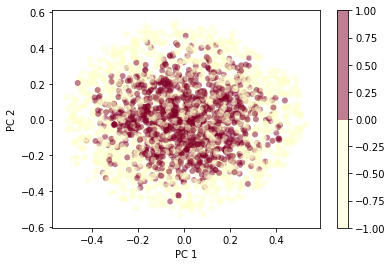

In [101]:
# plotting the two components
plt.scatter(projected[:, 0], projected[:, 1],
            c=Ytrain, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('YlOrRd', 2))
plt.xlabel('PC 1')
plt.ylabel( 'PC 2')
plt.colorbar();
# it seems that 1 is contained within -1 with 1 taking a slightly smaller area, 
# yet they are very similar


It seems that 1 class is contained within -1, i.e. - class -1 has a somehow higher range. Apart from that, the both classes are very similar. 

### Scree graph

In [102]:
# Starting  with the maximum of PCs for a scree plot
pca_big = PCA(n_components=784, random_state = 10)
pca_big.fit(Xnormalized)

X_pca_big = pca_big.fit_transform(Xnormalized)

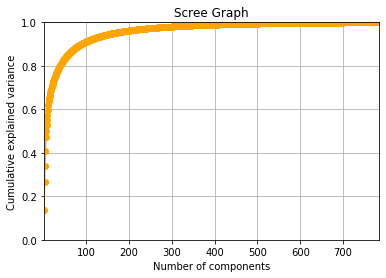

In [103]:
# Plotting scree map
plt.plot(np.arange(len(pca_big.explained_variance_ratio_))+1,
         np.cumsum(pca_big.explained_variance_ratio_),'o-', color='orange')
plt.axis([1,len(pca_big.explained_variance_ratio_),0,1])
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.title('Scree Graph')
plt.grid()
plt.show()

It seems that 95% of variation is explained in the 100-200 PC bracket. Trying different values, I find that 165 PCs explain 95% of variance.

In [104]:
pca_165 = PCA(n_components=165, random_state = 10)
pca_165.fit(Xnormalized)

X_pca_165 = pca_165.fit_transform(Xnormalized)

# calculating total variance explained
sum(pca_165.explained_variance_ratio_)
# so need 165 PCAs to explain 95% of variation

0.9506244917885548

### Kernalized SVM on PCA data

I start by running a grid search for the best parameters of Kernalized SVM using the reduced PCA data. I choose completelly arbitrary parameters aiming to covers full parameter space.

In [ ]:
# Kernalized SVM on 165 PC data.

parameters_pc = [{'kernel': ['poly'], 'degree': [2, 3, 4, 5], 'C': [0.01, 0.1, 1, 10, 100]},
              {'kernel': ['rbf'], 'gamma': [1e-4, 1e-2, 1, 10], 'C': [0.01, 0.1, 1, 10, 100]}]

svc = SVC(class_weight = 'balanced')
pc_clf = GridSearchCV(svc, parameters_pc, scoring = 'roc_auc', cv=skf)
pc_clf.fit(X_pca_165, Ytrain)

In [ ]:
# printing the best results
print(pc_clf.best_params_, "ROC-AUC:", pc_clf.best_score_)

# The result is marginally lower than that of non-reduced data

The most optimal kernel appears to be again RBF with C = 1 and $\gamma = 10$. The corresponding ROC-AUC score (0.8731) is almost the same as that achieved with non-reduced data. 

Overall, using 165 principal component versus the non-reduced data brings the loss of ROC-AUC score equal to approximatelly 0.00274. So we do not gain better classification performance, yet in the case of a huge data, PCA could help with computational efficiency. Nonetheless, in this particular case, in order to maximise classification, I would use the non-reduced data.

The most optimal Support Vector Machine case, had a lower regulating term C which implies that more reguliarization is needed whilst using the PCA data. Overall, PCA data could be used as a replacement for SVM models due to the computational efficiency and a marginal loss in predictive power.

The breakdown of the most optimal SVM model with RBF kernel, $\gamma = 10$ and $C = 1$ is presented bellow.

In [105]:
# setting RBF, gamma = 10, C=1 to get full score breakdown

PC_SVM = SVC(C = 1 , class_weight = 'balanced', kernel = 'rbf', gamma = 10)

PC_SVM_scores, PC_SVM_stds = evaluation_metrics(X_pca_165, classifier = PC_SVM, has_decision_function = True)
# 0.87 ROC-AUC.

ROC-AUC scores for each fold; [0.8628119761594337, 0.8739057552616875, 0.8706113801452784, 0.8812511640901471, 0.877015447391431]
ROC-AUC: 0.87 (+/- 0.01)
PR-AUC scores for each fold; [0.7752674853360729, 0.7869352924391505, 0.7620460247868845, 0.7882889894655779, 0.7891851558647345]
AUC-PR: 0.78 (+/- 0.02)
Accuracy score for each fold; [0.7783333333333333, 0.795, 0.8133333333333334, 0.8016666666666666, 0.7866666666666666]
Accuracy: 0.80 (+/- 0.02)


In [106]:
print("Score:", PC_SVM_scores, "Stand. Dev:", PC_SVM_stds)

Score: {'roc': 0.8731191446095956, 'pr': 0.7803445895784842, 'accuracy': 0.795} Stand. Dev: {'roc': 0.00623628537811247, 'pr': 0.010443379979163026, 'accuracy': 0.012064640713902583}


### XGBoosting

I start by running a grid search for the best parameters of XGBoosting using the reduced PCA data. I choose completelly arbitrary parameters aiming to covers full parameter space. 

In [5]:
# Grid Search of XGBoosting parameters

parameters_T = [{'colsample_bytree': [1, 0.6, 0.3], 'colsample_bylevel': [1, 0.6, 0.3], 
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.1, 0.3], 'max_depth':[3, 6, 10, 12]}]

xgb_T = xgb.XGBClassifier()
xgb_T = GridSearchCV(xgb_T, parameters_T, scoring = 'roc_auc')
xgb_T.fit(X_pca_165, Ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'colsample_bylevel': [1, 0.6, 0.3],
                          'colsample_bytree': [1, 0.6, 0.3],
                          'learning_rate': [0.1, 0.

In [6]:
# shaping the results into the dataframe for a better inspection if needed.
resxgb_T = pd.DataFrame(xgb_T.cv_results_)

{'colsample_bylevel': 0.6, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200} 0.8798424008548054


In [ ]:
# printing the best parameters with the corresponding ROC-AUC score
print(xgb_T.best_params_, xgb_T.best_score_)

The most optimal XGBoosting parameters yields ROC-AUC of roughly 0.8798. This is the highest score so far exceeding even that of the RBF SVM with the non-reduced data. I would expect the score to increase further if the samee XGBoosting with the same parameters was applied on a normalized but non-reduced data. 

In order to improve the classification score even further, I conduct another one grid search. This time I am looking around the parameters which were optimal now. 

In [40]:
# Narrower grid search for XGBoosting

parameters_T2 = [{'colsample_bytree': [1, 0.9, 0.8], 'colsample_bylevel': [0.7, 0.6, 0.5], 
                'n_estimators': [180, 200, 220],
                'learning_rate': [0.1, 0.2], 'max_depth':[9, 10, 11]}]

xgb_T2 = xgb.XGBClassifier()
xgb_T2 = GridSearchCV(xgb_T2, parameters_T2, scoring = 'roc_auc')
xgb_T2.fit(X_pca_165, Ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'colsample_bylevel': [0.7, 0.6, 0.5],
                          'colsample_bytree': [1, 0.9, 0.8],
                          'learning_rate': [0.1, 

In [41]:
# shaping the results into the dataframe for a better inspection if needed.
resxgb_T2 = pd.DataFrame(xgb_T2.cv_results_)

In [42]:
# printing the best parameters with the corresponding ROC-AUC score
print(xgb_T2.best_params_, xgb_T2.best_score_)

{'colsample_bylevel': 0.7, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 180} 0.8807196101153687


The score is even better. Setting XGBoosting with these parameters to get the full performance evaluation.

In [107]:
xgb_class_def = xgb.XGBClassifier(colsample_bylevel=0.7, colsample_bytree=0.9,
                                  learning_rate=0.1, max_depth=11, n_estimators=180)

xgb_score, xgb_std = evaluation_metrics(X_pca_165, classifier=xgb_class_def)
# 0.8807 ROC-AUC

ROC-AUC scores for each fold; [0.8632776122182902, 0.877269975786925, 0.8941260011175265, 0.8876303780964798, 0.8812940833576217]
ROC-AUC: 0.88 (+/- 0.02)
PR-AUC scores for each fold; [0.7857418975496746, 0.8033533884302925, 0.8300493894600632, 0.8178805232500818, 0.8076633438357043]
AUC-PR: 0.81 (+/- 0.03)
Accuracy score for each fold; [0.77, 0.8, 0.8083333333333333, 0.815, 0.8]
Accuracy: 0.80 (+/- 0.03)


In [49]:
xgb_score
# 0.8807 ROC-AUC

{'roc': 0.8807196101153687,
 'pr': 0.8089377085051632,
 'accuracy': 0.7986666666666666}

## Question 5

Since the XGBoosting with colsample_bylevel = 0.7, colsample_bytree = 0.9, learning_rate = 0.1, 
 max_depth = 11, n_estimators = 180 gave the best results on PCA data exceeding even the results obtained by RBF SVM on a full normalized data, for my pipeline I will implement the same XGBoosting algorithm yet on the full normalized data. The reasoning behind is that when comparing RBF SVM on PCA and full data, full data still yielded slightly better results.

The pipeline is straightforward and follows two steps:
 1. Normalize the data based on L2 norm
 2. Fit XGBoosting classifier with colsample_bylevel = 0.7, colsample_bytree = 0.9, learning_rate = 0.1, max_depth = 11, n_estimators = 180 parameters. 

In [43]:
# Normalizing Xtest data.
Xtest_normalized = preprocessing.normalize(Xtest, norm='l2')

# Fitting the XGBoosting model
X_test_clsf = xgb.XGBClassifier(colsample_bylevel=0.7, colsample_bytree= 0.9, learning_rate= 0.1, 
 max_depth= 11, n_estimators= 180)

X_test_clsf.fit(Xnormalized, Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [44]:
# Extracting the corresponding scores. 
Y_test_predict = np.array(X_test_clsf.predict_proba(Xtest_normalized)[:,1])

# Changing printing options from the scientific notation to a simple decimal one. 
np.set_printoptions(suppress=True, precision=10)

# saving the file in the directory. 
np.savetxt("two.csv", Y_test_predict, delimiter=",", fmt='%f')

The above gave the prediction score in the class competition of 0.90. I will also try the XGBoosting with the optimal parameters found before doing a narrower search because owing to randomness of the data, the score might be higher for another setting.

In [47]:
# Fitting the XGBoosting model with previous optimal settings.

X_test_clsf_2 = xgb.XGBClassifier(colsample_bylevel=0.6, colsample_bytree= 1, learning_rate= 0.1, 
 max_depth= 10, n_estimators = 200)

X_test_clsf_2.fit(Xnormalized, Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
# Extracting the corresponding scores. 
Y_test_predict_2 = np.array(X_test_clsf_2.predict_proba(Xtest_normalized)[:,1])

# Changing printing options from the scientific notation to a simple decimal one. 
np.set_printoptions(suppress=True, precision=10)

# saving the file in the directory. 
np.savetxt("one.csv", Y_test_predict_2, delimiter=",", fmt='%f')

This specification yielded a predictino score of 0.9010 which is slightly higher than the one before. I thus, leave these predicted scores. 